In [1]:
from matplotlib.ticker import PercentFormatter, FuncFormatter

from record_preprocess import *

/Users/purchaser/miniforge3/envs/MMKP-solver/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
load_all_play_records()

Data sources loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_ali_static_MMKP_RR_partition_2023-02-28-19-20-18/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_ali_static_MMKP_2023-02-28-18-35-41/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_static_MMKP_RR_partition_2023-02-28-21-32-14/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_static_MMKP_RR_distribution_2023-02-28-22-17-06/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_trace_MMKP_2023-02-28-15-14-10/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_trace_MMKP_RR_partition

In [3]:

def plot_data_source_plan_GPU_distribution():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    col = 2
    fig, axes = plt.subplots(3, col, figsize=(12, 8))
    plan_GPU_options = [
        *{*np.arange(5, 105, 5)}, 200
    ]
    width = 0.15
    data_sources = [
        DataSourceName.DataSourceAli,
        DataSourceName.DataSourcePhi,
        DataSourceName.DataSourceAliFixNew,
        DataSourceName.DataSourcePhiFixNew,
        DataSourceName.DataSourceAliUni,
        DataSourceName.DataSourcePhiUni
    ]
    for i, data_source_name in enumerate(data_sources):
        record = extract_play_record(
            mode=SessionMode.Trace,
            data_source_name=data_source_name,
            cluster_name=ClusterName.Cluster10GPUs,
            scheduler_name=SchedulerName.MMKP_strict)
        if len(record) != 1:
            print(data_source_name)
        assert len(record) == 1
        record = record[0]
        plan_GPU_to_size = {opt: 0 for opt in plan_GPU_options}
        for job_spec in record.job_specs.values():
            plan_GPU_to_size[int(job_spec.plan_GPU)] += 1
        X = np.arange(len(plan_GPU_options))
        sizes = [plan_GPU_to_size[opt] for opt in plan_GPU_options]
        ax = axes[i // col, i % col]
        sizes = np.array(sizes) * 4
        ax.bar(X, sizes, width=width)
        xticks = ["", "10", "", "", "25", "", "", "", "", "50", "", "", "65", "", "", "", "85", "", "", "", ">100"]
        ax.set_xticks(X, xticks)
        ax.set_ylabel("# of Jobs")
        ax.set_xlabel("Computation Demands (%)")
        ax.set_title(f"{data_source_to_spec(data_source_name)['label']}")
    # fig.suptitle("Computation Quota Distribution for Each Workload")
    fig.tight_layout()
    save_fig(fig, output_path("workloads_comp_quota_distribution.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_data_source_runtime_distribution():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 32})
    fig, ax = plt.subplots(figsize=(16, 7))
    data_sources = [
        DataSourceName.DataSourceAliSta,
        DataSourceName.DataSourcePhiSta
    ]
    for data_source in data_sources:
        record = extract_play_record(mode=SessionMode.Trace,
                                     data_source_name=data_source,
                                     cluster_name=ClusterName.Cluster64,
                                     scheduler_name=SchedulerName.SPREAD)
        assert len(record) == 1
        record = record[0]
        runtimes = []
        for job_spec in record.job_specs.values():
            runtimes.append(job_spec.run_time)

        x = runtimes
        x = list(filter(lambda v: v < 300000, x))

        # N is the count in each bin, bins is the lower-limit of the bin
        # ax.hist(runtimes, bins=100)
        #
        x, y = sorted(x), np.arange(len(x)) / len(x)
        data_source_to_label = {
            DataSourceName.DataSourceAliSta: "Alibaba",
            DataSourceName.DataSourcePhiSta: "Philly"
        }
        ax.plot(x, y, label=data_source_to_label[data_source], linewidth=4)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.legend()
    ax.set_xticks([(i * 2 * 60 * 60) for i in range(1, 28, 4)])
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{int(v / (60 * 60))}"))
    ax.set_ylabel("CDF")
    ax.set_xlabel("Runtime (hour)")
    fig.tight_layout()
    save_fig(fig, output_path("workloads_CDF_runtime.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_data_source_submit_pattern():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 32})
    fig, ax = plt.subplots(figsize=(16, 7))

    c = get_config("../configs/MMKP_config.json")
    ali_trace_config = c.data_source_configs["data_source_ali_trace"]
    ali_trace_config.job_count = 2000
    phi_trace_config = c.data_source_configs["data_source_phi_trace"]
    phi_trace_config.data_range = (2300, 6000)
    phi_trace_config.submit_scale_factor = 1
    phi_trace_config.job_count = 2000
    ali = DataSource(data_source_config=ali_trace_config,
                   enabled_GPU_types={GPUType.RTX_2080Ti})
    phi = DataSource(data_source_config=phi_trace_config,
                     enabled_GPU_types={GPUType.RTX_2080Ti})

    data_sources = [
        (ali, DataSourceName.DataSourceAliDyn),
        (phi, DataSourceName.DataSourcePhiDyn)
    ]
    time_interval = 10 * 60
    from itertools import count

    for data_source, name in data_sources:
        submit_jobs_cnt = 0
        now = 0
        counter = count(0)
        X = list()
        Y = list()
        def update_data():
            nonlocal now, submit_jobs_cnt
            X.append(next(counter))
            Y.append(submit_jobs_cnt)
            now += time_interval
            submit_jobs_cnt = 1

        for job_spec in data_source.job_specs:
            if int(job_spec.submit_time_nano / 1e9) < now + time_interval:
                submit_jobs_cnt += 1
                continue
            update_data()
        update_data()

        data_source_to_label = {
            DataSourceName.DataSourceAliDyn: "ALI_DYN",
            DataSourceName.DataSourcePhiDyn: "PHI_DYN"
        }
        ax.plot(X, Y, label=data_source_to_label[name], linewidth=4)
    # ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.legend()
    ax.set_xticks([i * 6 for i in range(5, 45, 5)])
    ax.set_xticklabels([f"{i}\nhour" for i in range(5, 45, 5)])
    # ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{int(v / (60 * 60))}"))
    ax.set_ylabel("Number of Submitted Jobs")
    ax.set_xlabel("Time")
    fig.tight_layout()
    save_fig(fig, output_path("workloads_trace_submit_pattern.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})

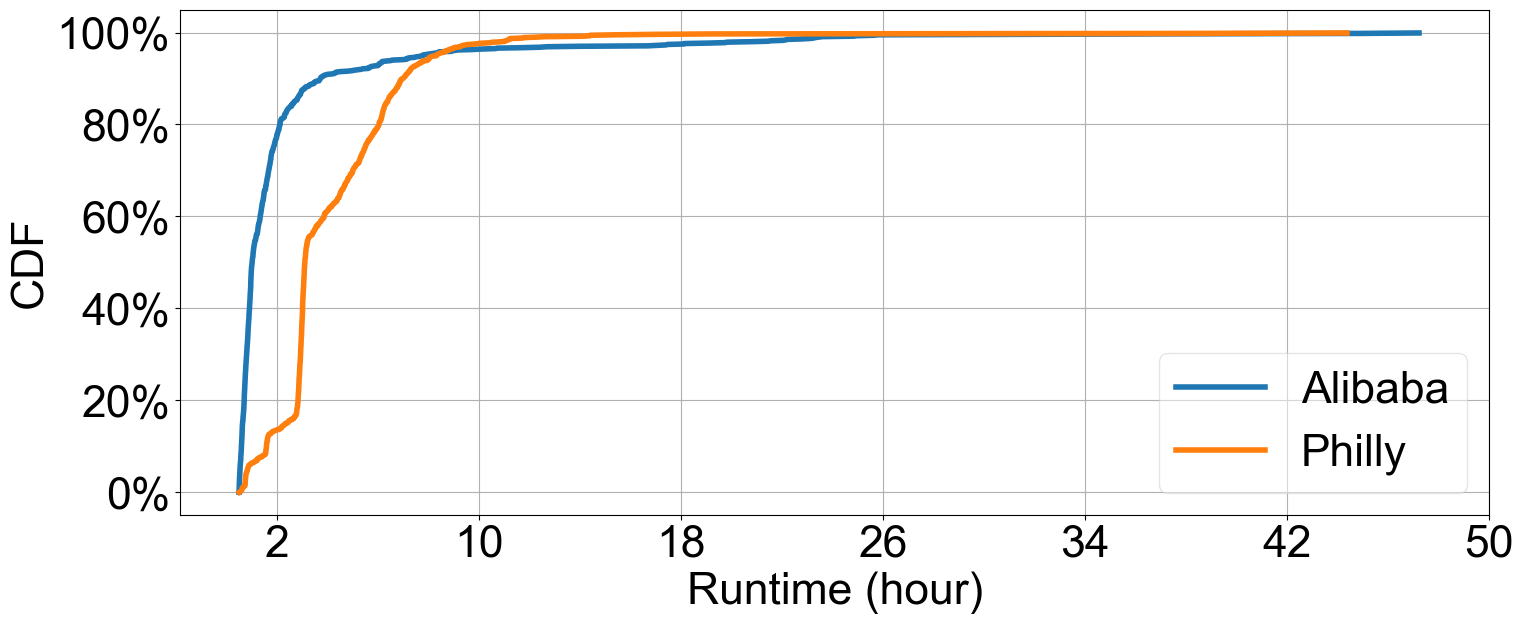

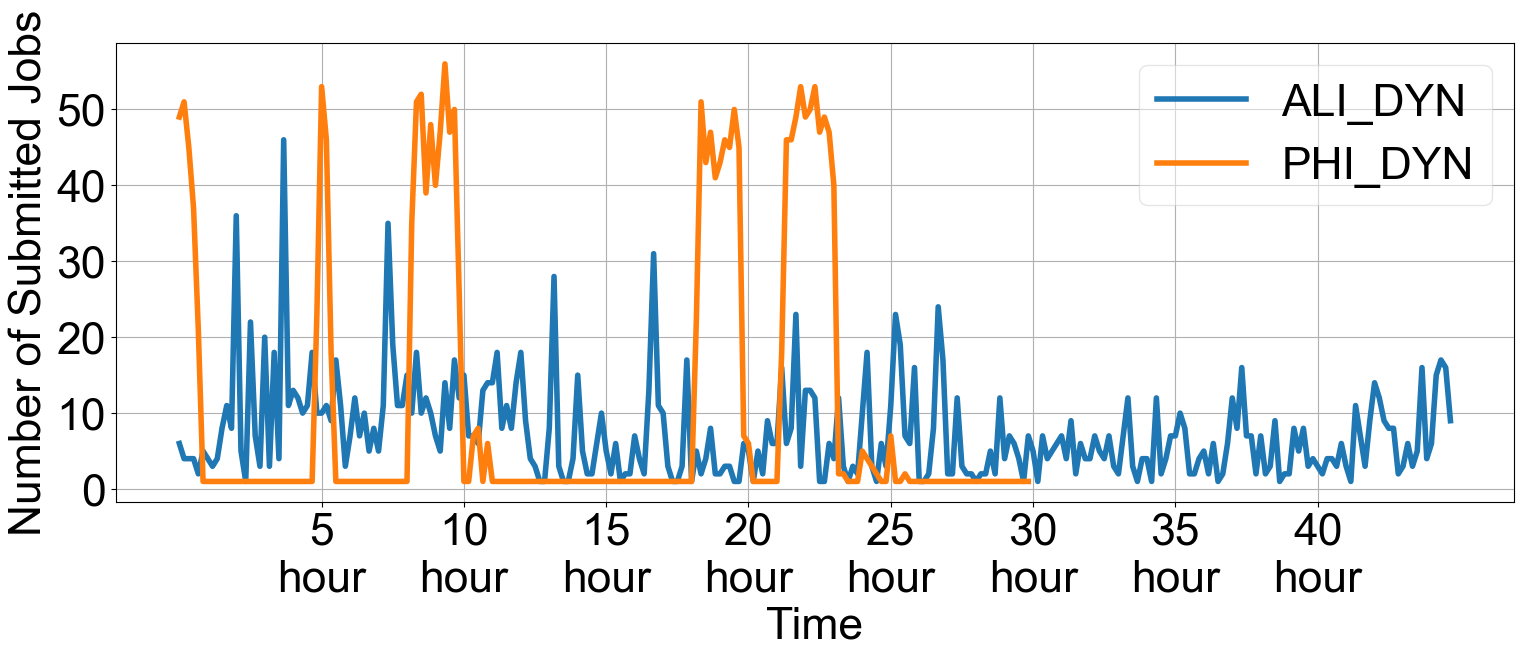

In [4]:

plot_data_source_runtime_distribution()
plot_data_source_submit_pattern()
